# 第8章 循环神经网络

- 本章将介绍另外一种常用的神经网络结构——循环神经网络（recurrent neural network，RNN）以及循环神经网络中的一个重要结构——长短时记忆网络（long short-term memory，LSTM）；本章还将介绍循环神经网络在时序分析问题中的应用

## 8.1 循环神经网络简介

- 传统的机器学习算法非常依赖于人工提取的特征，使得基于传统机器学习的图像识别、语音识别以及自然语言处理等问题存在特征提取的瓶颈；而基于全连接神经网络的方法也存在参数太多、无法利用数据中时间序列信息等问题；随着更加有效的循环神经网络结构被不断提出，循环神经网络挖掘数据中的时序信息以及语义信息的深度表达能力被充分利用，并在语音识别、语言模型、机器翻译以及时序分析等方面实现了突破
- 循环神经网络的主要用途是处理和预测序列数据；在之前介绍的全连接神经网络或卷积神经网络模型中，网络结构都是从输入层到隐含层再到输出层，层与层之间是全连接或部分连接的，但每层之间的节点是无连接的；循环神经网络的隐藏层之间的节点是有连接的，隐藏层的输入不仅包括输入层的输出，还包括上一时刻隐藏层的输出

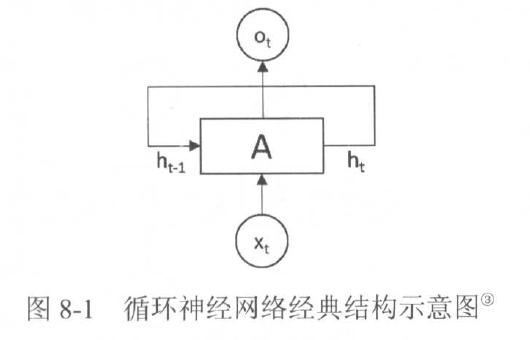
- 在很多模型中隐藏状态$h_t$也被直接用于输出，这类模型可以看作$o_t=h_t$的特例，一些资料直接用$h_t$同时代表这两个输出
- 由于模块A中的运算和变量在不同时刻是相同的，因此循环神经网络理论上可以被看做是同一神经网络结构被无限复制的结果；正如卷积神经网络在不同的空间位置共享参数，循环神经网络是在不同时间位置共享参数，从而能够使用有限的参数处理任意长度的序列
- 对于时间序列数据来说（比如不同时刻商品的销量），每一时刻的输入样例可以是当前时刻的数值（比如销量值）；对于语言模型来说，输入样例可以是当前单词对应的单词向量（word embedding）
- 循环神经网络唯一的区别在于因为它每个时刻都有一个输出，所以循环神经网络的总损失为所有时刻（或者部分时刻）上的损失函数的总和

In [1]:
import numpy as np

X = [1, 2]
state = [0.0, 0.0]
# 分别定义不同输入部分的权重以方便操作
w_cell_state = np.asarray([[0.1, 0.2], [0.3, 0.4]])
w_cell_input = np.asarray([0.5, 0.6])
b_cell = np.asarray([0.1, -0.1])

# 定义用于输出的全连接层参数
w_output = np.asarray([[1.0], [2.0]])
b_output = 0.1

# 按照时间顺序执行循环神经网络的前向传播过程
for i in range(len(X)):
    # 计算循环体中的全连接层神经网络
    before_activation = np.dot(state, w_cell_state) + X[i] * w_cell_input + b_cell
    state = np.tanh(before_activation)
    
    # 根据当前状态计算最终输出
    final_output = np.dot(state, w_output) + b_output
    
    # 输出每个时刻的信息
    print "before activation: ", before_activation
    print "state: ", state
    print "output: ", final_output

before activation:  [0.6 0.5]
state:  [0.53704957 0.46211716]
output:  [1.56128388]
before activation:  [1.2923401  1.39225678]
state:  [0.85973818 0.88366641]
output:  [2.72707101]


- 和其它神经网络类似，在定义损失函数之后，套用第4章中介绍的优化框架TensorFlow就可以自动完成模型训练的过程；这里唯一需要特别指出的是，理论上循环神经网络可以支持任意长度的序列，然而在实际训练过程中，如果序列过长，一方面会导致优化时出现梯度消散和梯度爆炸的问题，另一方面，展开后的前馈神经网络会占用过大的内存，所以实际中一般会规定一个最大长度，当序列长度超过规定长度之后会对序列进行截断

## 8.2 长短时记忆网络（LSTM）结构

- 循环神经网络通过保存历史信息来帮助当前的决策，例如使用之前出现的单词来加强对当前文字的理解；循环神经网络可以更好地利用传统神经网络结构所不能建模的信息，但同时，这也带来了更大的技术挑战——长期依赖（long-term dependencies）问题
- 在复杂语言场景中，有用信息的间隔有大有小、长短不一，循环神经网络的性能也会受到限制

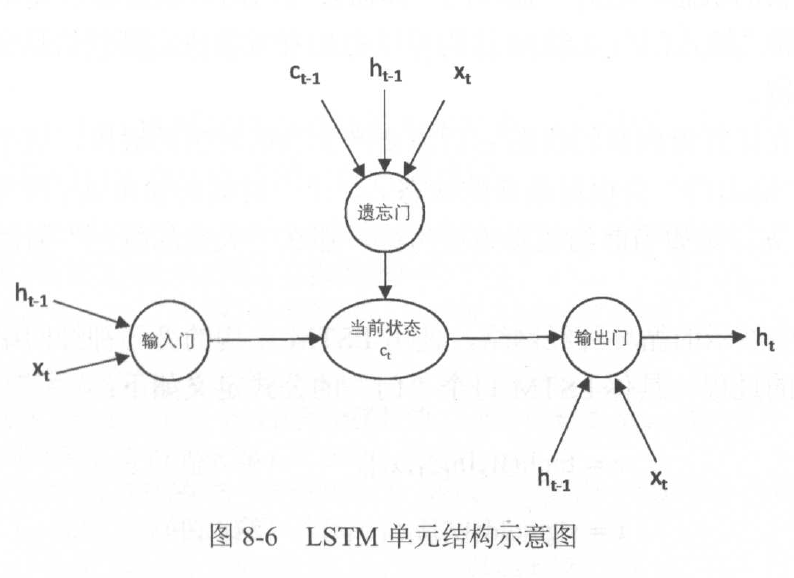

- LSTM靠一些“门”的结构让信息有选择性地影响循环神经网络中每个时刻的状态；所谓“门“的结构就是一个使用sigmoid神经网络和一个按位做乘法的操作，这两个操作合在一起就是一个“门”的结构；之所以该结构叫做“门”是因为使用sigmoid作为激活函数的全连接神经网络层会输出一个0到1之间的数值，描述当前输入有多少信息量可以通过这个结构；于是这个结构的功能就类似一扇门，当门打开时（sigmoid神经网络层输出为1时），全部信息都可以通过；当门关上时（sigmoid神经网络层输出为0时），任何信息都无法通过

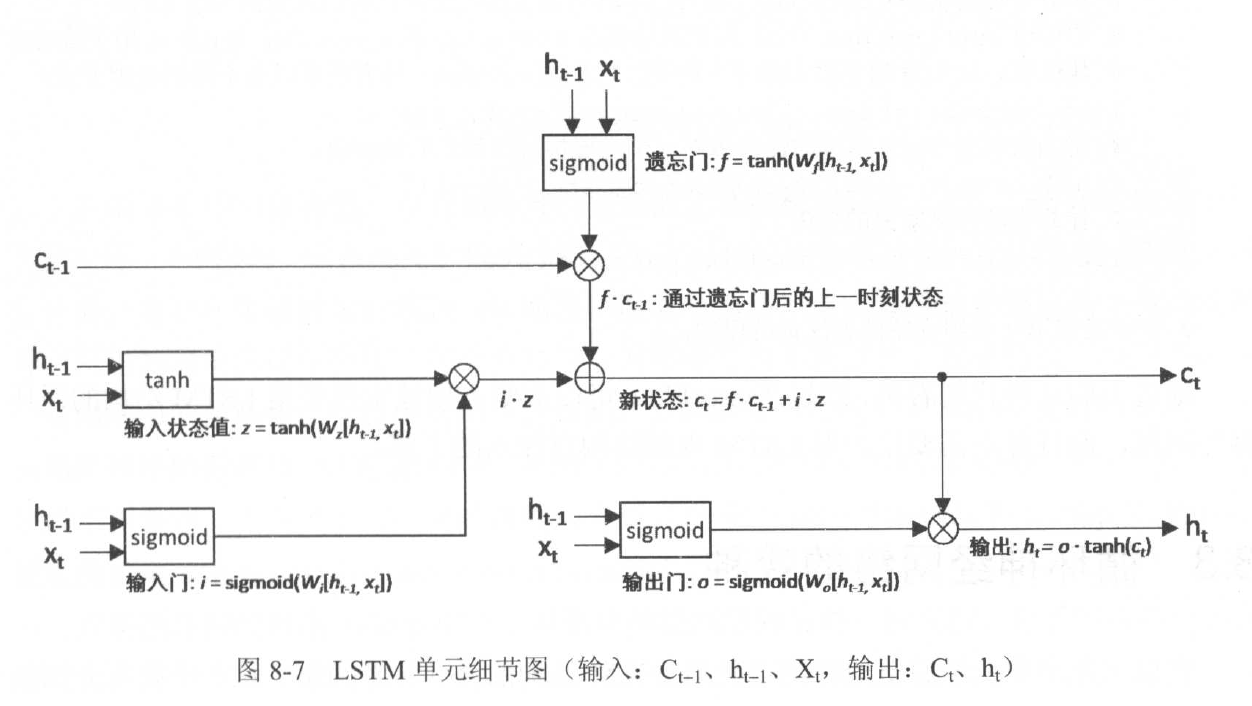

In [2]:
# 定义一个LSTM结构；在TensorFlow中通过一句简单的命令就可以实现一个完整的LSTM结构；LSTM中使用的变量也会在该函数中自动被声明
lstm = tf.nn.rnn_cell.BasicLSTMCell(lstm_hidden)

# 将LSTM中的状态初始化为全0数组；BasicLSTMCell类提供了zero_state函数来生成全零的初始状态；state是一个包含两个张量的LSTMStateTuple类，其中state.c和state.h分别对应了上图中的c状态和h状态
state = lstm.zero_state(batch_size, tf.float32)

# 定义损失函数
loss = 0.0
# 虽然在测试时循环神经网络可以处理任意长度的序列，但是在训练中为了将循环网络展开成前馈神经网络，我们需要知道训练数据的序列长度，在以下代码中，用num_steps来表示这个长度；第9章中介绍使用dynamic_rnn动态处理变长序列的方法
for i in range(num_steps):
    # 在第一个时刻声明LSTM结构中使用的变量，在之后的时刻都需要复用之前定义好的变量
    if i > 0:
        tf.get_variable_scope().reuse_variables()
        
    # 每一步处理时间序列中的一个时刻；将当前输出current_input（上图中的x_t）和前一时刻状态state（h_{t-1}和c_{t-1}）传入定义的LSTM结构
    # 可以得到当前LSTM的输出lstm_output（h_t）和更新后的状态state（h_t和c_t）；lstm_output用于输出给其他层，state用于输出给下一时刻
    # 它们在dropout等方面可以有不同的处理方式
    lstm_output, state = lstm(current_input, state) # state包含了lstm_output
    # 将当前时刻LSTM结构的输出传入一个全连接层得到最后的输出
    final_output = fully_connected(lstm_output)
    # 计算当前时刻输出的损失
    loss += calc_loss(final_output, expected_output)
    
# 使用类似第4章中介绍的方法训练模型

NameError: name 'tf' is not defined

- 通过上面这段代码看出，TensorFlow可以非常方便地实现使用LSTM结构的循环神经网络，而且并不需要用户对LSTM内部结构有深入的了解

## 8.3 循环神经网络的变种

- 这一节将介绍循环神经网络的几个常用变种以及它们所解决的问题，同时也会给出如何使用TensorFlow来实现这些变种

### 8.3.1 双向循环神经网络和深层循环神经网络

- 在经典的循环神经网络中，状态的传输是从前往后单向的；然而，在有些问题中，当前时刻的输出不仅和之前的状态有关系，也和之后的状态相关，这时就需要使用双向循环神经网络（bidirectional RNN）来解决这类问题
- 双向循环神经网络是由两个独立的循环神经网络叠加在一起组成的，输出由这两个循环神经网络的输出拼接而成
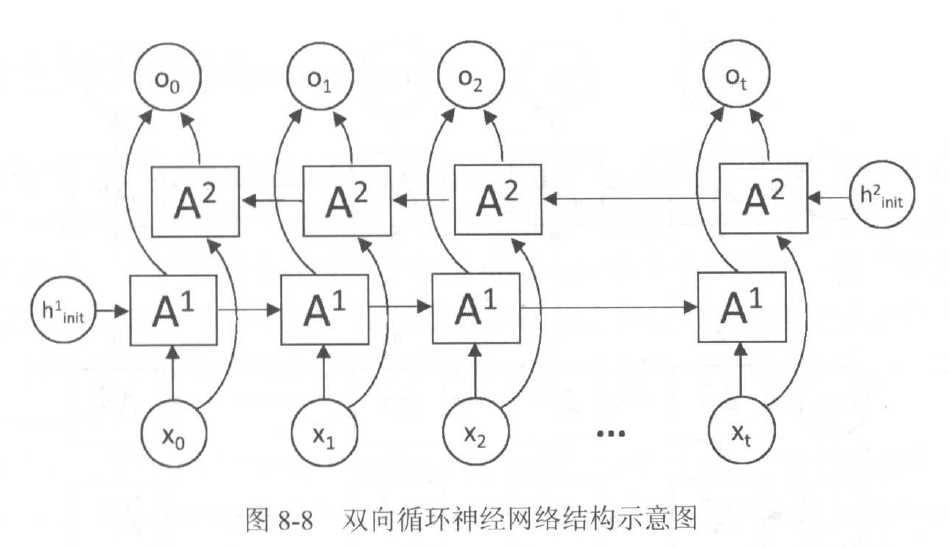
- 双向循环神经网络的主体结构就是两个单向循环神经网络的结合；在每一个时刻t，输入会同时提供给这两个方向相反的循环神经网络；两个网络独立进行计算，各自产生该时刻的新状态和输出，而双向循环网络的最终输出是这两个单向循环神经网络的输出的简单拼接；两个循环神经网络除方向不同以外，其余结构完全对称；每一层网络中的循环体可以自由选用任意结构，如前面介绍过的简单RNN、LSTM均可；双向循环神经网络的前向传播过程和单向的循环神经网络十分类似，这里不再赘述

- 深层循环神经网络（Deep RNN）是循环神经网络的另外一种变种；为了增强模型的表达能力，可以在网络中设置多个循环层，将每层循环网络的输出传给下一层进行处理；如下图所示，在一个L层的深层循环网络中，每一时刻的输入x_t到输出o_t之间有L个循环体，网络因此可以从输入中抽取更加高层的信息；和CNN类型，每一层的循环体中参数是一致的，而不同层中的参数可以不同；为了更好地支持深层循环神经网络，TensorFlow中提供了MultiRNNCell类来实现深层循环神经网络的前向传播过程
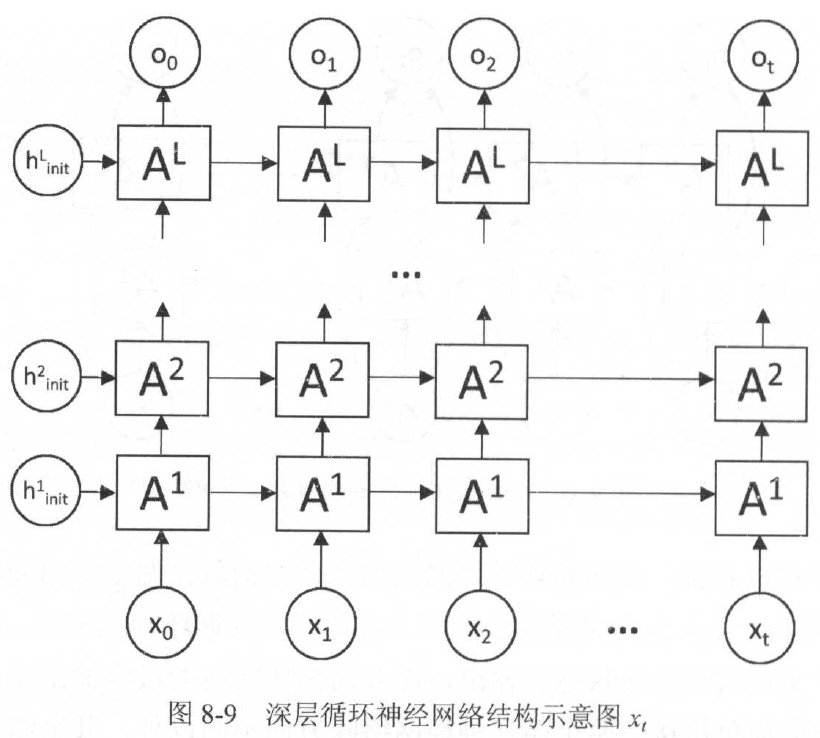

In [3]:
# 定义一个基本的LSTM结构作为循环体的基础结构；深层循环神经网络也支持使用其它的循环体结构
lstm_cell = tf.nn.rnn_cell.BasicLSTMCell
# 通过MultiRNNCell类实现深层循环神经网络中每一个时刻的前向传播过程；其中number_of_layers表示有多少层
stacked_lstm = tf.nn.rnn_cell.MultiRNNCell([lstm_cell(lstm_size) for _ in range(number_of_layers)])

# 和经典的循环神经网络一样，可以通过zero_state函数来获取初始状态
state = stacked_lstm.zero_state(batch_size, tf.float32)

# 和上一节一样，计算每一时刻的前向传播结果
for i in range(len(num_steps)):
    if i > 0:
        tf.get_variable_scope().reuse_variables()
    stacked_lstm_output, state = stacked_lstm(current_input, state)
    final_output = fully_connected(stacked_lstm_output)
    loss += calc_loss(final_output, expected_output)

NameError: name 'tf' is not defined

- 从以上代码可以看出，在TensorFlow中只需要在BasicLSTMCell的基础上再封装一层MultiRNNCell就可以非常容易地实现深层循环神经网络了

### 8.3.2 循环神经网络的dropout

- 6.4节介绍过在CNN上使用dropout的方法，通过dropout，可以让CNN更加robust；类似地，在RNN中使用dropout也有同样的功能，而且，类似CNN中只在最后的全连接层中使用dropout，RNN一般只在不同层循环体结构之间使用dropout，而不再同一层的循环体结构之间使用；也即，从时刻t-1传递到时刻t时，RNN不会进行状态的dropout，而在同一时刻t中，不同层循环体之间会使用dropout

- 在TensorFlow中，使用tf.nn.rnn_cell.DropoutWrapper类可以很容易实现dropout功能

In [4]:
# 定义LSTM结构
lstm_cell = tf.nn.rnn_cell.BasicLSTMCell

# 使用DropoutWrapper类来实现dropout功能，该类通过两个参数来控制dropout的概率，一个参数为input_keep_prob，它可以用来控制输入的dropout概率，另一个为output_keep_prob，它可以用来控制输出的dropout概率
stacked_lstm = rnn_cell.MultiRNNCell([tf.nn.rnn_cell.DropoutWrapper(lstm_cell(lstm_size)) for _ in range(number_of_layers)])

# 和8.3.1l类似，运行前向传播过程

NameError: name 'tf' is not defined

## 8.4 循环神经网络样例应用

In [5]:
# coding = utf8
import numpy as np
import tensorflow as tf

# 加载matplotlib工具包，使用该工具可以对预测的sin函数曲线进行绘图
import matplotlib as mpl
mpl.use('Agg')
from matplotlib import pyplot as plt

HIDDEN_SIZE = 30 # LSTM隐藏节点的个数
NUM_LAYERS = 2 # LSTM的层数

TIMESTEPS= 10 # 循环神经网络的训练序列长度
TRAINING_STEPS = 10000 # 训练轮数
BATCH_SIZE = 32 # batch大小

TRAINING_EXAMPLES = 10000 # 训练数据个数
TESTING_EXAMPLES = 1000 # 测试数据个数
SAMPLE_GAP = 0.01 # 采样间隔

def generate_data(seq):
    X = []
    y = []
    # 序列的第i项和后面的TIMESTEPS-1项合在一起作为输入；第i+TIMESTEPS项作为输出；
    # 即用sin函数前面的TIMESTEPS个点的信息，预测第i+TIMESTEPS个点的函数值
    for i in range(len(seq) - TIMESTEPS):
        X.append([seq[i: i + TIMESTEPS]])
        y.append([seq[i + TIMESTEPS]])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

def lstm_model(X, y, is_training):
    # 使用多层的LSTM结构
    cell = tf.nn.rnn_cell.MultiRNNCell([tf.nn.rnn_cell.BasicLSTMCell(HIDDEN_SIZE) for _ in range(NUM_LAYERS)])
    
    # 使用TensorFlow接口将多层的LSTM结构连接成RNN网络并计算其前向传播结果
    outputs, _ = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    # outputs是顶层LSTM在每一步的输出结果，它的维度是[batch_size, time, HIDDEN_SIZE]，在本问题中只关注最后一个时刻的输出结果
    output = outputs[:, -1, :]
    
    # 对LSTM网络的输出层再做加一层全连接层并计算损失，注意这里默认的损失为均方差损失
    predictions = tf.contrib.layers.fully_connected(output, 1, activation_fn=None)
    
    # 只在训练时计算损失函数和优化步骤，测试时直接返回预测结果
    if not is_training:
        return predictions, None, None
    
    # 计算损失函数
    loss = tf.losses.mean_squared_error(labels=y, predictions=predictions)
    
    # 创建模型优化器并得到优化步骤
    train_op = tf.contrib.layers.optimize_loss(loss, tf.train.get_global_step(), optimizer='Adagrad', learning_rate=0.1)
    return predictions, loss, train_op

def train(sess, train_X, train_y):
    # 将训练数据以数据集的方式提供给计算图
    ds = tf.data.Dataset.from_tensor_slices((train_X, train_y))
    ds = ds.repeat().shuffle(1000).batch(BATCH_SIZE)
    X, y = ds.make_one_shot_iterator().get_next()
    
    # 调用模型，得到预测结果、损失函数，和训练操作
    with tf.variable_scope("model"):
        predictions, loss, train_op = lstm_model(X, y, True)
    
    # 初始化变量
    sess.run(tf.global_variables_initializer())
    for i in range(TRAINING_STEPS):
        _, l = sess.run([train_op, loss])
        if i % 100 == 0:
            print "train step: " + str(i) + ", loss: " + str(l)
            
def run_eval(sess, test_X, test_y):
    # 将测试数据以数据集的方式提供给计算图
    ds = tf.data.Dataset.from_tensor_slices((test_X, test_y))
    ds = ds.batch(1)
    X, y = ds.make_one_shot_iterator().get_next()
    
    # 调用模型得到计算结果，这里不需要输入真实的y值
    with tf.variable_scope("model", reuse=True):
        prediction, _, _ = lstm_model(X, [0.0], False)
    
    # 将预测结果存入一个数组
    predictions = []
    labels = []
    for i in range(TESTING_EXAMPLES):
        p, l = sess.run([prediction, y])
        predictions.append(p)
        labels.append(l)
    
    # 计算rmse作为评价指标
    predictions = np.array(predictions).squeeze()
    labels = np.array(labels).squeeze()
    rmse = np.sqrt(((predictions - labels) ** 2).mean(axis=0))
    print "Mean Square Error is: %f" % rmse
    
    # 对预测的sin函数曲线进行绘图
    plt.figure()
    plt.plot(predictions, label='predictions')
    plt.plot(labels, label='real_sin')
    plt.legend()
    plt.show()
    
# 用正弦函数生成训练和测试数据集合
# numpy.linspace函数可以创建一个等差序列的数组，它常用的参数有三个参数，第一个参数表示起始值，第二个参数表示终止值，第三个参数表示数列的长度；例如，linespace(1, 10, 10)产生的数组是array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
test_start = (TRAINING_EXAMPLES + TIMESTEPS) * SAMPLE_GAP
test_end = test_start + (TESTING_EXAMPLES + TIMESTEPS) * SAMPLE_GAP
train_X, train_y = generate_data(np.sin(np.linspace(0, test_start, TRAINING_EXAMPLES + TIMESTEPS, dtype=np.float32)))
test_X, test_y = generate_data(np.sin(np.linspace(test_start, test_end, TESTING_EXAMPLES + TIMESTEPS, dtype=np.float32)))

with tf.Session() as sess:
    # 训练模型
    train(sess, train_X, train_y)
    # 使用训练好的模型对测试数据进行预测
    run_eval(sess, test_X, test_y)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.cast instead.
train step: 0, loss: 0.56138736
train step: 100, loss: 0.005475263
train step: 200, loss: 0.005492648
train step: 300, loss: 0.004411189
train step: 400, loss: 0.0027516019
train step: 500, loss: 0.0023469867
train step: 600, loss: 0.0014015024
train step: 700, loss: 0.0013806804
tr